In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import torch
from torch import nn
from torchvision import models, transforms, datasets
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
from torchvision.models import VGG16_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu' #checking for gpu

reverse_genredict = {0:"blues", 1:"classical", 2:"country", 3:"disco", 4:"hiphop", 5:"jazz", 6:"metal", 7:"pop", 8:"reggae",9:"rock"}
genre_array = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

class MusicGenres(data.Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    name = str(self.annotations.iloc[index,0])
    y_label = self.genre_dict[str(self.annotations.iloc[index,59])]
    im = torch.load(self.root_dir+name+'.pt')
    im = torch.unsqueeze(im,axis=0)
    im = torch.tile(im,(3,1,1))
    if self.transform:
      im = self.transform(im)

    return (im, y_label)


path_tensors = "/content/drive/MyDrive/Colab Notebooks/spectrogram_tensors/"
csv_file = '/content/drive/MyDrive/Colab Notebooks/features_3_sec.csv'
dataset = MusicGenres(csv_file = csv_file, root_dir = path_tensors)
length = len(dataset)
split = 0.15
test_size = int(length*split)
train_size = length - test_size
traindata, testdata = data.random_split(dataset, [train_size, test_size])


class MusicClassifier(nn.Module):
  def __init__(self):
    super(MusicClassifier, self).__init__()
    self.sequential = nn.Sequential(
        nn.Conv2d(1,1,3),
        nn.Flatten(),
        nn.Linear(12032,1024),
        nn.Linear(1024,10),
        nn.Softmax()
    )

  def forward(self,x):
    probabilities = self.sequential(x)
    return probabilities


def saveModel(model):
    PATH = "entire_model.pt"
    torch.save(model.state_dict(), PATH)

def testAccuracy(model, test_loader):

    model.to(device)
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in test_loader:

            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    accuracy = (100 * accuracy / total)
    return accuracy


def train(model, num_epochs, loss_fn, train_loader, test_loader, optimizer):
    print("The model will be running on", device, "device")
    model.to(device)

    for epoch in range(num_epochs):
        size = len(train_loader.dataset)

        for batch, (images, labels) in enumerate(train_loader, 0):

            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            pred = model(images)
            loss = loss_fn(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        accuracy = testAccuracy(model, test_loader)
        print('For epoch', epoch+1,'the test accuracy over the entire test set is %d %%' % (accuracy))



if __name__ == '__main__':
    batch_size = 200
    train_loader1 = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                              shuffle=True,num_workers=2)
    test_loader1 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                              shuffle=True,num_workers=2)

    model1 = models.vgg16(weights=VGG16_Weights.DEFAULT)
    num_filters = model1.classifier[-1].in_features
    model1.classifier[-1] = nn.Linear(num_filters,10)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=0.0001)

    train(model = model1,num_epochs=15,train_loader = train_loader1, test_loader = test_loader1, loss_fn=loss_fn,optimizer=optimizer)
    print('Finished Training')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 126MB/s]


The model will be running on cpu device
loss: 8.554237  [    0/ 8492]
loss: 4.365062  [  200/ 8492]
loss: 2.783620  [  400/ 8492]
loss: 7.017977  [  600/ 8492]
loss: 4.841037  [  800/ 8492]
loss: 2.359827  [ 1000/ 8492]
loss: 2.307280  [ 1200/ 8492]
loss: 3.613041  [ 1400/ 8492]
loss: 2.486557  [ 1600/ 8492]
loss: 2.511137  [ 1800/ 8492]
loss: 2.387741  [ 2000/ 8492]
loss: 2.324743  [ 2200/ 8492]
loss: 2.313169  [ 2400/ 8492]
loss: 2.302295  [ 2600/ 8492]
loss: 2.318471  [ 2800/ 8492]
loss: 2.298643  [ 3000/ 8492]
loss: 2.393841  [ 3200/ 8492]
loss: 2.313080  [ 3400/ 8492]
loss: 2.324798  [ 3600/ 8492]
loss: 2.385523  [ 3800/ 8492]
loss: 2.351254  [ 4000/ 8492]
loss: 2.317313  [ 4200/ 8492]
loss: 2.299613  [ 4400/ 8492]
loss: 2.329151  [ 4600/ 8492]
loss: 2.295318  [ 4800/ 8492]
loss: 2.301094  [ 5000/ 8492]
loss: 2.296458  [ 5200/ 8492]
loss: 2.318642  [ 5400/ 8492]
loss: 2.300761  [ 5600/ 8492]
loss: 2.302747  [ 5800/ 8492]
loss: 2.302541  [ 6000/ 8492]
loss: 2.300465  [ 6200/ 8492]


In [ ]:
import librosa
import torch
from torch import nn
from torchvision import models, transforms

PATH = "entire_model.pt"

# Load the audio file and preprocess it
audio_file = '/content/drive/MyDrive/Colab Notebooks/audio_sample_30s.wav'
audio, sr = librosa.load(audio_file)
mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr=sr)
preprocessed_audio = mel_spectrogram.reshape(1, 1, mel_spectrogram.shape[0], mel_spectrogram.shape[1])

# Convert the preprocessed audio into a tensor
audio_tensor = torch.from_numpy(preprocessed_audio)

# Load the trained model
model = models.vgg16(pretrained=False)
num_filters = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_filters, 10)
model.load_state_dict(torch.load(PATH))

# Pass the audio tensor through the model
model.eval()
with torch.no_grad():
    output = model(audio_tensor)

# Get the predicted label
predicted_label_index = torch.argmax(output).item()
predicted_label = reverse_genredict[predicted_label_index]

print('Predicted label:', predicted_label)

GPU is enabled in this notebook.


  0%|          | 0/50 [00:00<?, ?epoch/s]

<ipython-input-3-10ab2c6cc3b6>:169: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


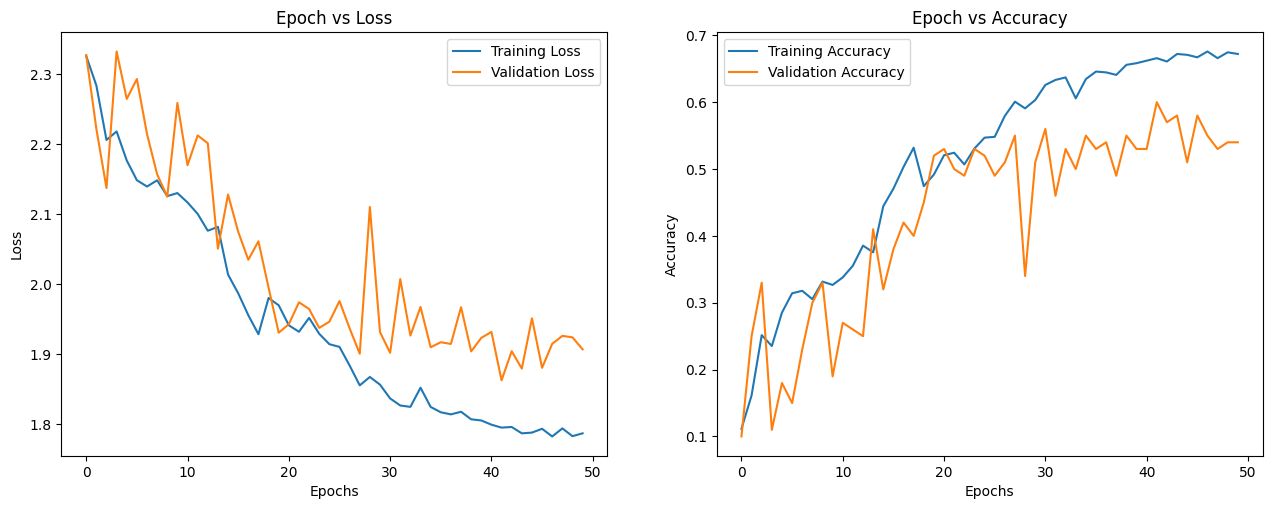

In [ ]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

device = set_device()

# Create folder with training, testing and validation data.

spectrograms_dir = "/content/drive/MyDrive/Colab Notebooks/images_original/"
folder_names = ['/content/drive/MyDrive/Colab Notebooks/Data/train/', '/content/drive/MyDrive/Colab Notebooks/Data/test/', '/content/drive/MyDrive/Colab Notebooks/Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

# Make a CNN & train it to predict genres.

# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=9856, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.3, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x, dim=1)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)